**GRASP-AND-LIFT EEG Detection Project**

This project aims to compare different machine learning models in terms of viability for detecting events from EEG signals.

In [115]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

**Introduction**

Training data consists of EEG recordings of subjects performing grasp-and-lift trials.

There are 12 subjects in total, 10 series of trials for each subject.

Each series recorded 32 EEG channels with sampling rate 500Hz.

Training data contains id columns, representing the subject, series, and time at which data point was recorded.


In [116]:
train_set_signals = pd.read_csv("../input/train/subj1_series1_data.csv")
train_set_signals.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


The aim is to predict whether a certain event is occuring at a given point.

There are 6 events. If an event occured at a given point is represented by 1, 0 otherwise.      


In [117]:
train_set_labels = pd.read_csv("../input/train/subj1_series1_events.csv")
train_set_labels.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


Setup for visualizations

In [118]:
labels = train_set_labels.columns.drop('id')
labelNames = labels.values

In [119]:
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))

In [120]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.4)
        i+=1      
    

In [121]:
def vizualize_predictions(signals, predictions, expected, labelName, limit=2000): 
    #0-31
    signalIndex = 10
    
    #Relevant only for multilabel predictions, else is always 0
    labelIndex = 0
                
    signals = pd.DataFrame(data=np.array(signals))
    axis = signals[signals.columns[signalIndex]].iloc[0:limit].plot(figsize=(20,4))  
        
    expected = pd.DataFrame(data = expected)    
    predictions = pd.DataFrame(data = np.around(predictions))
    
    expectedCropped = expected.iloc[0:limit,]
    predictionsCropped = predictions.iloc[0:limit,]
    
    highlight(expectedCropped[expectedCropped.iloc[:,labelIndex]==1].index, axis, "red")
    highlight(predictionsCropped[predictionsCropped.iloc[:,labelIndex]==1].index, axis, "black")
    
    red_patch = mpatches.Patch(color='red', label='Expected event')
    black_patch = mpatches.Patch(color='black', label='Predicted event')
    plt.legend(handles=[red_patch, black_patch])

    plt.title(labelName)
    plt.show()

Following graph shows five seconds of different recorded EEG channels with highlihted areas, which represent one of the events occuring. Events can overlap.

Our task is to predict those areas for unlabeled set of signals.

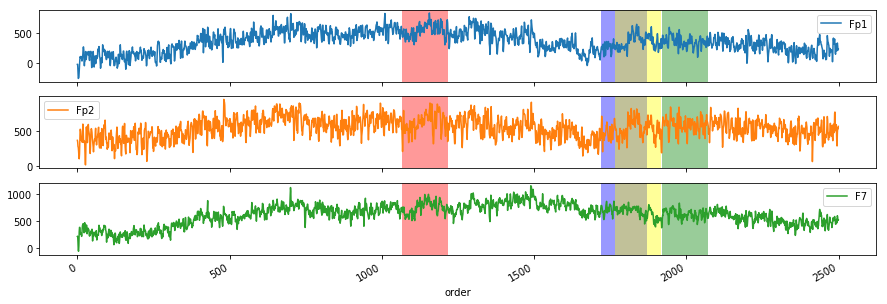

In [122]:
secondsToShow = 5
channelsToShow = 3
labelsToShow = 6

eeg_channels = train_set_signals.columns.drop('id')
sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","blue","yellow","green", "purple", "black"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,5))
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1

plt.show()

Helper methods for loading data

Features are standartized by removing the mean and scaling to unit variance

Further preprocessing can be done in *prepare_signals* function

In [123]:
import math
from sklearn.preprocessing import StandardScaler

def load_train_data(subject, series):
    train_set_signals = pd.read_csv(f"../input/train/subj{subject}_series{series}_data.csv")
    train_set_labels = pd.read_csv(f"../input/train/subj{subject}_series{series}_events.csv")
    return train_set_signals, train_set_labels
    
def load_all_test_data():
    signals_dfs=[]
    for i in range(1,13):
        for j in range(9,11):            
            signals = pd.read_csv(f"../input/test/subj{i}_series{j}_data.csv")
            signals_dfs.append(signals)
    return pd.concat(signals_dfs)       

def load_test_data(subject):
    signals_dfs=[]    
    for i in range(9,11):            
        signals = pd.read_csv(f"../input/test/subj{subject}_series{i}_data.csv")
        signals_dfs.append(signals)
    return pd.concat(signals_dfs) 

def load_test_data_series(subject, series):
    return pd.read_csv(f"../input/test/subj{subject}_series{series}_data.csv") 

def prepare_labels(data):    
    return data.drop("id", axis=1)
    
def prepare_signals(data):
    data = data.drop("id", axis=1)
    columns = data.columns      
    
    #Preprocessing    
    scaler = StandardScaler() 
    data =np.asarray(data.astype(float))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=columns) 
    
    return data
    
def load_train_data_prepared(subject, series):    
    signals, labels = load_train_data(subject,series)    
    return prepare_signals(signals), prepare_labels(labels)   

def split_data(data_to_split, percent):
    percenttotrainon = percent
    spliton = math.floor(float(len(data_to_split))*(percenttotrainon/float(100)))
    return data_to_split.iloc[:spliton], data_to_split[spliton:]   

def load_mass_data(fromsubj, tosubj): #we have 12 subjects
    signals_dfs=[]
    labels_dfs=[]
    for i in range(1,9): #we have 8 series availible for each subject
        for j in range(fromsubj, tosubj+1):
            signals, labels = load_train_data_prepared(subject=j, series=i)
            signals_dfs.append(signals)
            labels_dfs.append(labels)        

    signals_complete=pd.concat(signals_dfs)
    labels_complete=pd.concat(labels_dfs)
    return signals_complete, labels_complete 

def load_mass_data_subject(subject, fromseries, toseries): 
    signals_dfs=[]
    labels_dfs=[]
    for i in range(fromseries,toseries+1):        
        signals, labels = load_train_data_prepared(subject, series=i)
        signals_dfs.append(signals)
        labels_dfs.append(labels)        

    signals_complete=pd.concat(signals_dfs)
    labels_complete=pd.concat(labels_dfs)
    return signals_complete, labels_complete 

Helper for printing success rates for given predictions and expected values

In [124]:
def rd(x):
        return round(x)

def printSucc(predictions, expected, dataLabel):
    #success counters
    succ = 0
    onesTotal = 0
    onesSucc = 0
    
    #Compute successes in data
    for i in range(0, len(predictions)):    
        if(np.array_equal(list(map(rd, predictions[i])),expected[i])):
            succ+=1

        if 1 in expected[i]:
            onesTotal += 1           
            if(np.array_equal(list(map(rd, predictions[i])),expected[i])):
                onesSucc +=1           

    print(dataLabel, "success", "---","TOTAL =", "{:0.4f}".format(succ/len(predictions)), "|||","EVENT =","{:0.4f}".format(onesSucc/onesTotal) ,"(", onesSucc, "/",onesTotal, ")")    
    
    return succ/len(predictions), onesSucc/onesTotal

**LOGISTIC REGRESSION**

Logistic regression model.

The model is trained for each label (event) separately. 

In [125]:
from sklearn.linear_model import LogisticRegression
    
def logistic_regression_validation(model, subject, draw=False):
    trainon_signals, trainon_labels = load_mass_data_subject(subject = subject,fromseries=1,toseries=7)
    teston_signals, teston_labels = load_train_data_prepared(subject= subject,series=8)
        
    lr = model  
    #success rates for different labels
    successRates=[]  
    onesSuccessRates=[]
    #Train the model for each label separately
    for label in labels:
        #In sklearn framework, we can call fit method repeatedly, because it resets the model
        lr.fit(trainon_signals, trainon_labels[[label]].values.ravel())        
        
        #Test success for all data
        successRates.append(lr.score(teston_signals, teston_labels[[label]].values.ravel()))           
                
        #Test of success for 1's only
        predictions = lr.predict(teston_signals)        
        actual = teston_labels[[label]].values.ravel()        
        
        print(label,"label model evaluation")
        printSucc(predictions.reshape(len(predictions),1), actual.reshape(len(actual),1), "Testing")
        if(draw):
            vizualize_predictions(teston_signals, predictions, actual, labelName=label,limit=5000)        
        
        total = 0
        successes = 0 
        for i in range(0, len(actual)):            
            if(actual[i] == 1):               
                total+=1
                if(predictions[i] ==1):
                    successes+=1       
                    
        onesSuccessRates.append(successes/total)
                
        

    #Compute average success for all labels
    total_success_rate = sum(successRates)/len(successRates)
    total_success_rate_ones = sum(onesSuccessRates)/len(onesSuccessRates);  
    
    print("SUMMARY")
    print("TOTAL:", "{:1.4f}".format(total_success_rate)) 
    print("EVENTS","{:1.4f}".format(total_success_rate_ones))   
    
    
    

Testing of the model for given subject 

Evaluating each label success rate separarely and averaging them. Random behaviour has 50% success rate.

For given subject, we use first 7 series as training data and 8'th series as test data. 

Only a portion of data is visualized.

HandStart label model evaluation
Testing success --- TOTAL = 0.9565 ||| EVENT = 0.0124 ( 63 / 5100 )


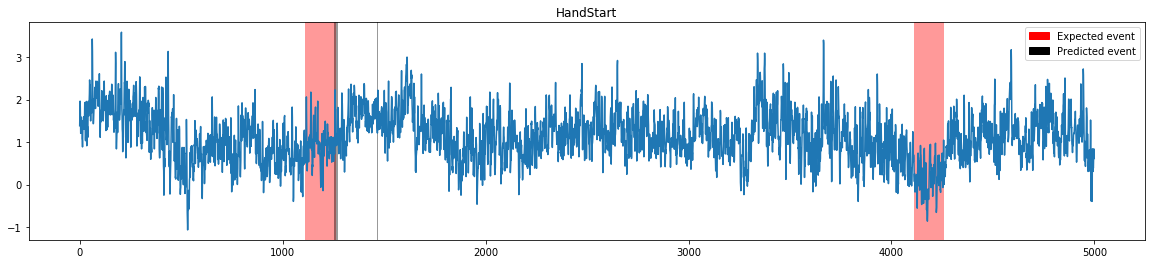

FirstDigitTouch label model evaluation
Testing success --- TOTAL = 0.9545 ||| EVENT = 0.0184 ( 94 / 5100 )


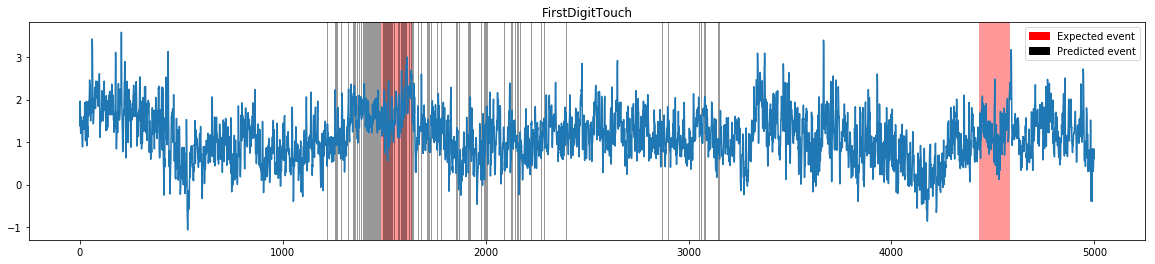

BothStartLoadPhase label model evaluation
Testing success --- TOTAL = 0.9561 ||| EVENT = 0.0055 ( 28 / 5100 )


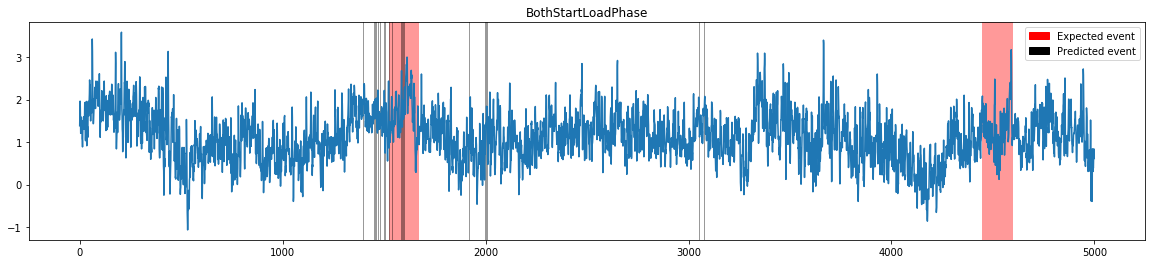

LiftOff label model evaluation
Testing success --- TOTAL = 0.9567 ||| EVENT = 0.0049 ( 25 / 5100 )


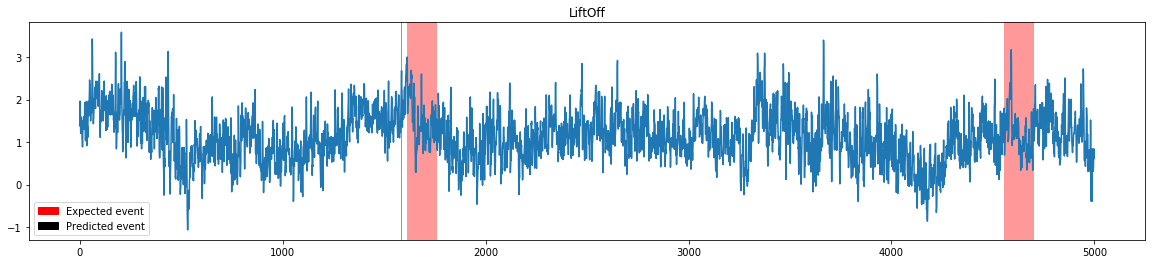

Replace label model evaluation
Testing success --- TOTAL = 0.9552 ||| EVENT = 0.0135 ( 69 / 5100 )


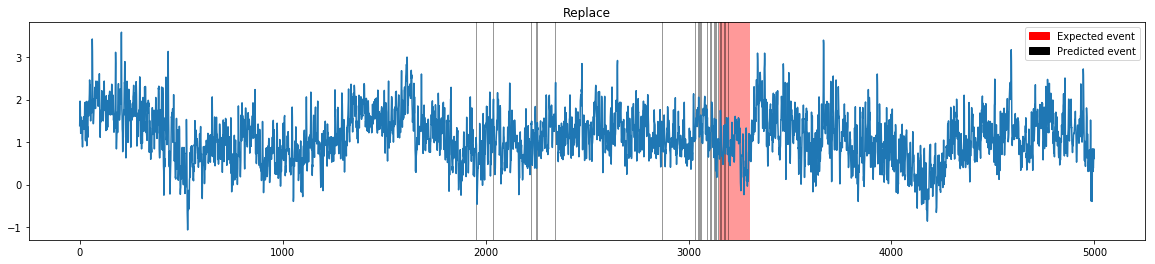

BothReleased label model evaluation
Testing success --- TOTAL = 0.9565 ||| EVENT = 0.0006 ( 3 / 5100 )


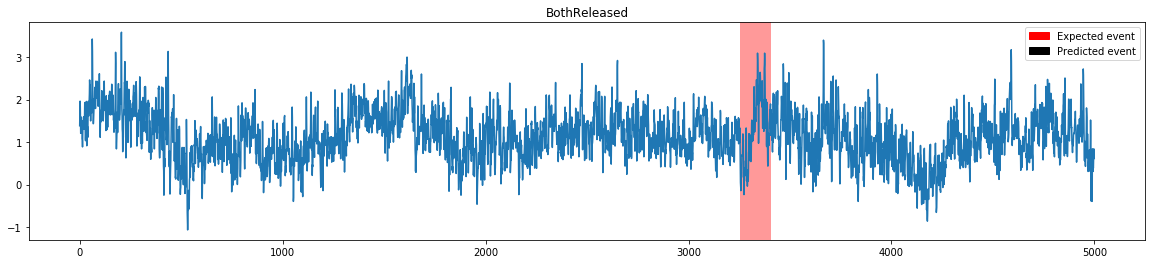

SUMMARY
TOTAL: 0.9559
ONES 0.0092


In [126]:
model = LogisticRegression(solver='lbfgs', max_iter = 1000)
logistic_regression_validation(model=model, subject= 1, draw=True)

Since input data are sparse (there are a lot more 0's than 1's), balanced mode is tried.

The “balanced” mode uses the values of labels to automatically adjust weights inversely proportional to class frequencies in the input data.

HandStart label model evaluation
Testing success --- TOTAL = 0.7033 ||| EVENT = 0.6625 ( 3379 / 5100 )


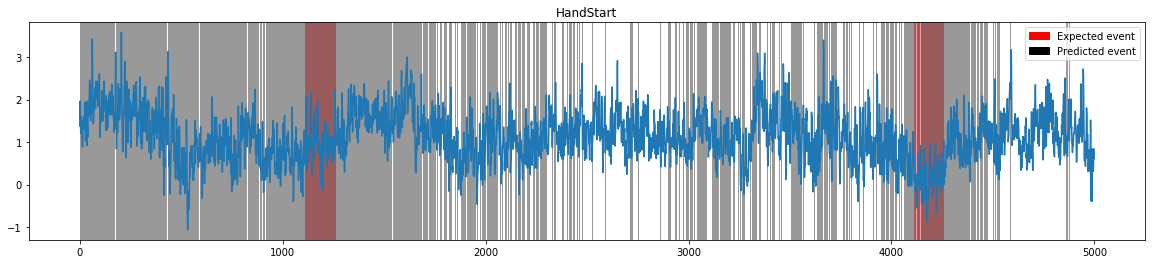

FirstDigitTouch label model evaluation
Testing success --- TOTAL = 0.7100 ||| EVENT = 0.5720 ( 2917 / 5100 )


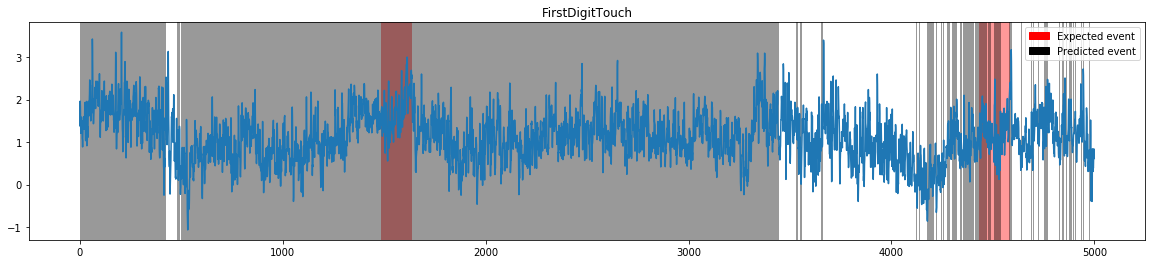

BothStartLoadPhase label model evaluation
Testing success --- TOTAL = 0.6893 ||| EVENT = 0.6200 ( 3162 / 5100 )


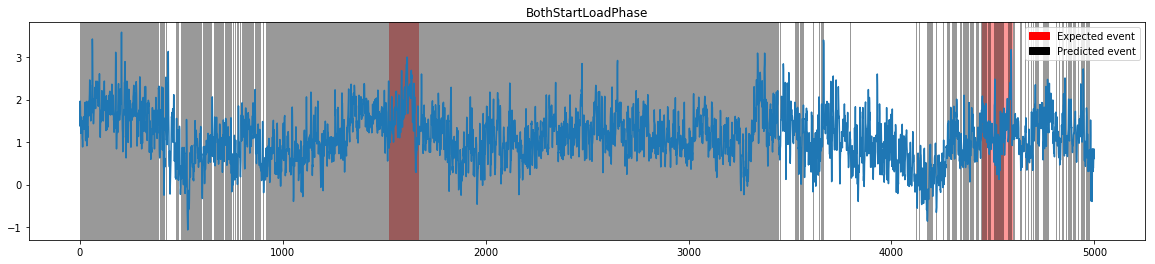

LiftOff label model evaluation
Testing success --- TOTAL = 0.7144 ||| EVENT = 0.7159 ( 3651 / 5100 )


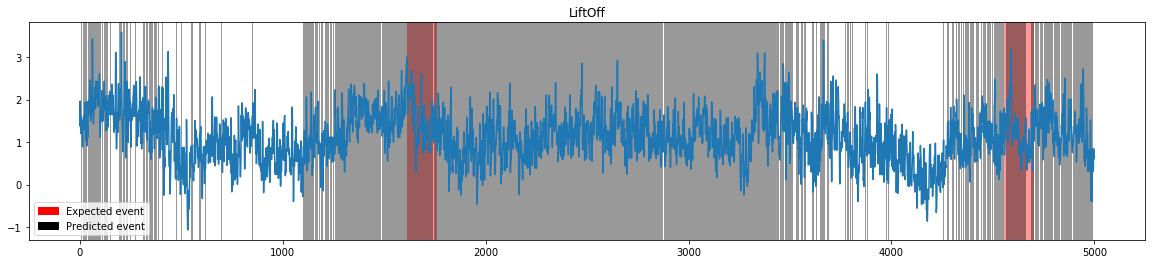

Replace label model evaluation
Testing success --- TOTAL = 0.7881 ||| EVENT = 0.8422 ( 4295 / 5100 )


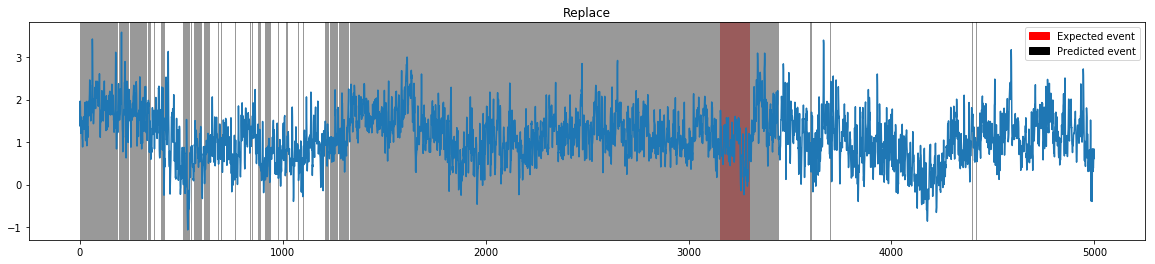

BothReleased label model evaluation
Testing success --- TOTAL = 0.7226 ||| EVENT = 0.7553 ( 3852 / 5100 )


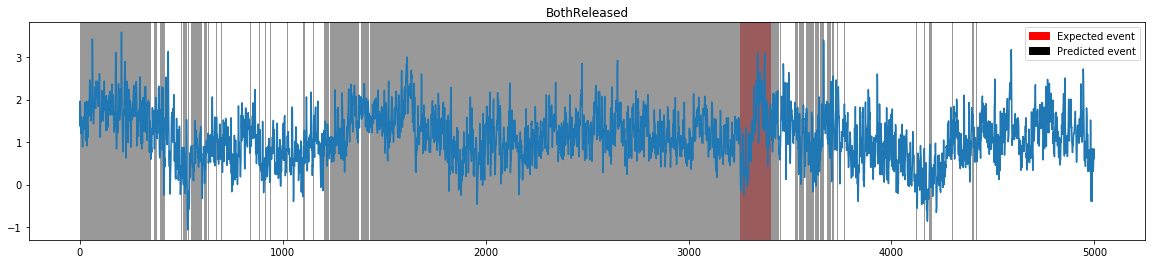

SUMMARY
TOTAL: 0.7213
ONES 0.6946


In [127]:
model = LogisticRegression(solver='lbfgs', max_iter = 1000, class_weight="balanced")
logistic_regression_validation(model=model, subject= 1, draw=True)

CSV file generation for competition submission

In [128]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_training(trainon_signals,trainon_labels,teston_signals):    
    lr = LogisticRegression(solver='lbfgs', max_iter = 1000, class_weight="balanced")
    
    ids = teston_signals["id"]
    teston_signals = prepare_signals(teston_signals)       
    
    result = np.empty((len(teston_signals),len(trainon_labels.columns)))    
    
    labelcounter = 0    
    for label in labels:        
        lr.fit(trainon_signals, trainon_labels[[label]].values.ravel())        
        predictions = lr.predict_proba(teston_signals)[:,1]
        result[:,labelcounter] = predictions 
        labelcounter+=1
    return result, ids
       

def logistic_regression_submission():
    results=[]
    results_ids=[]
    for i in range(1,13):         
        train_signals, train_labels = load_mass_data(i,i)
        test_signals = load_test_data(i)
        res, ids = logistic_regression_training(train_signals,train_labels,test_signals)
        results.append(res)
        results_ids.append(ids)
    
    
    submission_name = "balanced-logistic-submission.csv"
    submission = pd.DataFrame(columns=labelNames, data=np.concatenate(results), index=np.concatenate(results_ids))
    submission.to_csv(submission_name,index_label="id",float_format='%.3f')

# Csv generation
# logistic_regression_submission()

**RECURRENT NEURAL NETWORK**

RNN with LSTM, dropout and activation layers

* Adam optimizer
* Binary crossentropy loss 
* Sigmoid activation layer

Transform 2D dataset to 3D for LSTM layer - add floating window of *look_back* length

In [129]:
def create_sequences(dataset,labels, look_back=1):
    dataX = []
    dataY = labels[look_back:]
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), ])
    return np.array(dataX), np.array(dataY)


Tests given rnn model on predicting label or more labels from testing data.

Provides visualisations and success rates.





In [130]:
def evaluate_rnn(subject, model, config, LabelsRange, draw):
    #Last (8th) series is used as testing data
    test_signals, test_labels = load_train_data_prepared(subject=subject,series=8)
    
    #Creating sequences for lstm layer
    X_test_signals, X_test_labels = create_sequences(
        test_signals.values[::config.DOWNSAMPLING],
        test_labels.values[::config.DOWNSAMPLING],
        look_back=config.LOOK_BACK
    )
    #Selecting only desired labels
    X_test_labels = X_test_labels[:,LabelsRange[0]:LabelsRange[1]] 

    #Last few data points that do not fit batch size are omitted 
    croppedSize = math.floor(len(X_test_signals)/config.BATCH_SIZE)*config.BATCH_SIZE    

    #Prediction for testing data
    predictions = model.predict(X_test_signals[0:croppedSize], batch_size=config.BATCH_SIZE)
    expected = X_test_labels[0:croppedSize]
    
    #Selecting only desired labels   
    labelsPredicted = len(predictions[0])
    if(labelsPredicted == 1):
        predictions = predictions[:,0:1]
    else: #6 labels predicted    
        predictions = predictions[:,LabelsRange[0]:LabelsRange[1]] 
    
            
    #Success rate printing    
    totalPercent, onesPercent = printSucc(predictions,expected, dataLabel="Testing")
    
    #Vizualization
    if(draw):
        vizualize_predictions(
            test_signals.values[::config.DOWNSAMPLING][config.LOOK_BACK:croppedSize+config.LOOK_BACK:],
            predictions,
            expected,
            labelName = labelNames[LabelsRange[0]],  
            limit = 1000
        )
    
    return totalPercent, onesPercent    

Training of a single model for a single or more subjects.

Uses series 1-7 (leaves series 8 for testing)

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

def train_rnn(subjects, labelToTrain, trainSeparateLabels, config, modelGenerator, callbacks): 
    #Calculating output size of trained model
    LabelsRange = [labelToTrain,labelToTrain+1]
    if(not trainSeparateLabels):
        LabelsRange = [0,6]
    OutputSize = LabelsRange[1] - LabelsRange[0]     
    #Model creation
    model = modelGenerator(config, output_size = OutputSize) 
    
    #Training
    for i in range(config.ITERATIONS):
        #For specified subjects
        for subject in subjects:
            #For series 1-7 
            for j in range(1,8):
                signals, labels = load_train_data_prepared(subject = subject,series = j) 
                #Create sequences
                X_train_signals, X_train_labels = create_sequences(
                    signals.iloc[::config.DOWNSAMPLING].values,
                    labels.iloc[::config.DOWNSAMPLING].values,
                    look_back=config.LOOK_BACK       
                )        

                X_train_labels = X_train_labels[:,LabelsRange[0]:LabelsRange[1]]
                croppedSize = math.floor(len(X_train_signals)/config.BATCH_SIZE)*config.BATCH_SIZE        
                #Train model on relevant label (calling fit repeatedly in keras doesnt reset the model)
                model.fit(
                    X_train_signals[0:croppedSize],
                    X_train_labels[0:croppedSize],
                    epochs=config.EPOCHS,
                    batch_size=config.BATCH_SIZE,
                    shuffle=config.SHUFFLE,
                    verbose=config.VERBOSE,
                    callbacks=callbacks
                )            
                if(config.STATEFUL):
                    model.reset_states()
    
    
    print("FITTING DONE")
    return model, LabelsRange

Training of model for given subjects and evaluating it.

Evaluating each label success rate separarely and averaging them. Random behaviour has 50% success rate.

For given subject, we use first 7 series as training data and 8'th series as test data. 

In [132]:
def rnn_validation(subjects, modelGenerator, trainSeparateLabels, callbacks, draw=False, subjectToEvaluateOn = 1):
    config = Config()
    totalPercentages = []
    onesPercentages = []   
    
    model = None
    labelsRange = None
    
    #One model for training on all labels combined
    if(not trainSeparateLabels):
        model, labelsRange = train_rnn(
            subjects=subjects,
            labelToTrain = -1, #doesnt matter
            trainSeparateLabels = False,
            config = config,
            modelGenerator = modelGenerator,
            callbacks=callbacks
        )   
    
    for i in range (0,6):
        #Separate models for training all labels separately
        if(trainSeparateLabels):
            model, labelsRange = train_rnn(  
                subjects = subjects,
                labelToTrain=i,
                trainSeparateLabels=True,
                config=config,
                modelGenerator = modelGenerator,
                callbacks=callbacks
                )
        print(labelNames[i],"label model evaluation")
        
        total, ones = evaluate_rnn(subjectToEvaluateOn, model, config, LabelsRange=[i,i+1], draw = draw)
        totalPercentages.append(total)
        onesPercentages.append(ones)        

    print("SUMMARY")
    print("TOTAL :", sum(totalPercentages)/len(totalPercentages))
    print("ONES :", sum(onesPercentages)/len(onesPercentages))

RNN configuration

In [133]:
def create_basic_rnn_model(config, output_size):      
    model = Sequential()
    model.add(LSTM(50,batch_input_shape=(config.BATCH_SIZE,config.LOOK_BACK,32),
                   return_sequences=False, stateful=config.STATEFUL, dropout=0.5, activation="softsign"))     
    model.add(Dense(output_size, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model 

def create_stacked_rnn_model(config, output_size):      
    model = Sequential()
    model.add(LSTM(50,batch_input_shape=(config.BATCH_SIZE,config.LOOK_BACK,32), return_sequences=True, stateful=config.STATEFUL, dropout=0.5, activation="softsign")) 
    model.add(LSTM(50, return_sequences=False, stateful=config.STATEFUL, dropout=0.5, activation="softsign"))     
    model.add(Dense(output_size, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

class Config(object):
    #TODO explain downsampling
    DOWNSAMPLING = 15
    LOOK_BACK = 35
    BATCH_SIZE = 512

    #Iterations on stateful model, epochs on non-stateful
    EPOCHS = 30
    ITERATIONS = 1
    STATEFUL = False
    SHUFFLE = not STATEFUL
    VERBOSE = 0    

In [134]:
from keras.callbacks import EarlyStopping

callbacks=[EarlyStopping(monitor="acc", verbose=0, patience=10, restore_best_weights=True)]

Basic model, training all labels separately for single subject

Restoring model weights from the end of the best epoch
Epoch 00015: early stopping
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
FITTING DONE
HandStart label model evaluation
Testing success --- TOTAL = 0.9527 ||| EVENT = 0.2265 ( 77 / 340 )


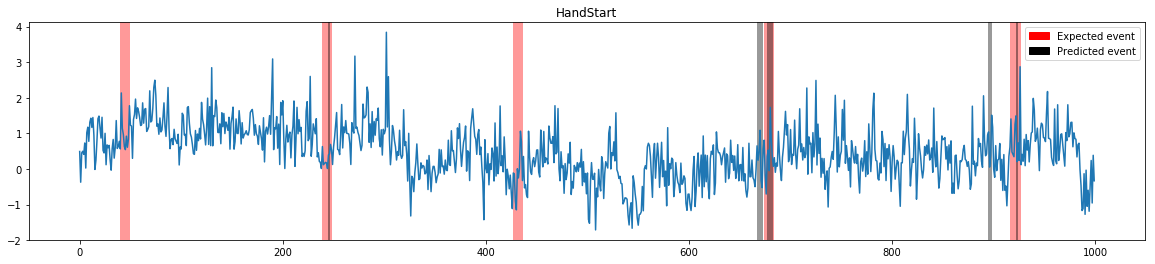

KeyboardInterrupt: 

In [135]:
rnn_validation(subjects=[1],
               modelGenerator = create_basic_rnn_model,
               trainSeparateLabels=True,
               draw=True,
               subjectToEvaluateOn=1,
               callbacks=callbacks
              )

Basic model, training all labels at once for single subject

In [ ]:
rnn_validation(subjects=[4],
               modelGenerator = create_basic_rnn_model,
               trainSeparateLabels=False,
               draw=True,
               subjectToEvaluateOn=4,
               callbacks=callbacks
              )

Stacked model, training all labels separately for single subject

In [ ]:
rnn_validation(subjects=[10],
               modelGenerator = create_stacked_rnn_model,
               trainSeparateLabels=True,
               draw=True,
               subjectToEvaluateOn=10,
               callbacks=callbacks
              )

Stacked model, training all labels at once for single subject

In [ ]:
rnn_validation(subjects=[9],
               modelGenerator = create_stacked_rnn_model,
               trainSeparateLabels=False,
               draw=True,
               subjectToEvaluateOn=9,
               callbacks=callbacks
              )

Basic model, training all labels at once for all subjects

In [ ]:
rnn_validation(subjects=list(range(1,13)),
               modelGenerator = create_basic_rnn_model,
               trainSeparateLabels=False,
               draw=True,
               subjectToEvaluateOn=7,
               callbacks=callbacks
              )

CSV file generation for competition submission

Some datapoints are not predicted (didnt fit batch size or are at the beginning of sequence).
Those data points are predicted as vectors of 0's (no event)

In [ ]:
def rnn_model_submission(config, modelGenerator, trainAllLabels):   
    results=[]
    results_ids=[]
    callbacks=[EarlyStopping(monitor="acc", verbose=1, patience=20, restore_best_weights=True)]
    #Train models for each subject
    for i in range(1,13):
        print("Training subject", i)
        #separate models for each subject           
        model = modelGenerator(config, output_size = 6)
        single_label_models = list() 
        for j in range(0,6):
            single_label_models.append(modelGenerator(config, output_size = 1))
        
        #Train on all training data
        for j in range(1,9):                   
            train_signals, train_labels = load_train_data_prepared(subject = i,series = j)
            train_signals, train_labels = create_sequences(
                train_signals.iloc[::config.DOWNSAMPLING].values,
                train_labels.iloc[::config.DOWNSAMPLING].values,
                look_back = config.LOOK_BACK)            
            
            croppedSize = math.floor(len(train_signals)/config.BATCH_SIZE)*config.BATCH_SIZE 
            
            #Training all labels at once (predicting vector of all labels)
            if(trainAllLabels):                
                for k in range(config.ITERATIONS):
                    model.fit(
                        train_signals[0:croppedSize],
                        train_labels[0:croppedSize],
                        epochs=config.EPOCHS,
                        batch_size=config.BATCH_SIZE,
                        shuffle=config.SHUFFLE,
                        verbose=config.VERBOSE,
                        callbacks=callbacks
                    )
                    if(config.STATEFUL):
                        model.reset_states()
            #Training all labels separately
            else:                
                for k in range(0,len(single_label_models)):
                    labelModel = single_label_models[k]
                    for l in range(config.ITERATIONS):
                        labelModel.fit(
                            train_signals[0:croppedSize],
                            #training only for specific label
                            train_labels[0:croppedSize,k:k+1],
                            epochs=config.EPOCHS,
                            batch_size=config.BATCH_SIZE,
                            shuffle=config.SHUFFLE,
                            verbose = config.VERBOSE,
                            callbacks=callbacks
                        )
                        if(config.STATEFUL):
                            labelModel.reset_states()
        
        #Generating results for testing data
        for j in range(9,11):
            
            test_signals = load_test_data_series(subject = i, series = j)
            ids = test_signals["id"]
            teston_signals = prepare_signals(test_signals)            
                                  
            omittedByDownsampling = len(teston_signals)%config.DOWNSAMPLING            
            teston_signals, ignored_labels = create_sequences(teston_signals.iloc[::config.DOWNSAMPLING].values, [], look_back=config.LOOK_BACK)            
            
            croppedSize = math.floor(len(teston_signals)/config.BATCH_SIZE)*config.BATCH_SIZE 
            omitted = len(teston_signals)%config.BATCH_SIZE
            
            result = None
            #Predicting vector of all labels
            if(trainAllLabels):
                result = model.predict(teston_signals[0:croppedSize], batch_size=config.BATCH_SIZE)
            #Predicting each label separately and concat them into one vector
            else:
                result = list()
                labelModelsPredictions = list()
                for labelModel in single_label_models:
                    labelPredictions = labelModel.predict(teston_signals[0:croppedSize], batch_size=config.BATCH_SIZE)
                    labelModelsPredictions.append(labelPredictions)
                for k in range(len(labelModelsPredictions[0])): 
                    resultVector = list()
                    for prediction in labelModelsPredictions:
                        resultVector.append(prediction[k,0])
                    result.append(resultVector)
                    
            #No predictions at the beginning of the data (floating window start). Padding with vectors of 0's
            for k in range(config.LOOK_BACK*config.DOWNSAMPLING):
                results.append(np.array([[0,0,0,0,0,0]]))            
            
            result = np.array(result)
            for element in result:                    
                #Multiplying each result because of downsampling
                for l in range(config.DOWNSAMPLING):                    
                    results.append(np.array([element]))       
            
            #No predictions for data outside of batch size, padding with vectors of 0's
            for k in range((omitted*config.DOWNSAMPLING)+omittedByDownsampling):
                results.append(np.array([[0,0,0,0,0,0]]))
                
            results_ids.append(ids)
            
            resultslen = len(np.concatenate(results))
            idslen = len(np.concatenate(results_ids))
            
            #Removing extra 0's at the end of predictions, now this is ugly
            for k in range(0, resultslen-idslen):
                results.pop(-1)          
   
    
    print("submitting")
    submission_name = "basic-rnn-submission.csv"            
    
    submission = pd.DataFrame(columns=labelNames, data=np.concatenate(results), index=np.concatenate(results_ids))
    submission.to_csv(submission_name,index_label="id",float_format='%.3f')

In [ ]:
class SubConfig(object):
    DOWNSAMPLING = 15
    LOOK_BACK = 35
    BATCH_SIZE = 512
    
    EPOCHS = 50
    ITERATIONS = 1
    STATEFUL = False
    SHUFFLE = not STATEFUL
    VERBOSE = 0   

config = SubConfig()
# rnn_model_submission(config, modelGenerator=create_basic_rnn_model, trainAllLabels=True)